## Setup, Loading Data and CDFs

In [1]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
CWD = os.getcwd()
from reporting import *
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results")
np.random.seed(0)

In [3]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

Name the notebook:
gray_diagonal_wavelet_full_agriVision.ipynb


In [4]:
sample = group_data_map[6]
r1, eta1, scale1 = 0.4, -0.1, 5.957e-1
r2, eta2, scale2 = 0.1, 3.8, 5.992e-17
n_samples = 5000

In [5]:
def visualize_cdf_pdf(params1, params2, sample=[], distro='gengamma', log_scale=True, n_samples=2000, interval=None, provided_loc=None, group=None, percent_excluded=0.1, plot_hist=True, bw=0.05, bw_log=0.05, binwidth=None):
    """
    Visualize the gap between the empirical CDF/PDF and the Computed CDF/PDF for two sets of parameters.

    Args:
        params1 (list): First set of distribution parameters.
        params2 (list): Second set of distribution parameters.
        sample (np.ndarray): Observed data.
        distro (str): Distribution type ('gengamma', 'gaussian', 'laplace').
        log_scale (bool): Whether to use log scale for PDF plots.
        n_samples (int): Number of samples for the computed CDF/PDF.
        interval (tuple): Interval for x-axis.
        provided_loc (float): Specific location to highlight.
        group (int or None): Group index (for titling purposes).
        percent_excluded (float): Percentage of data to exclude from the tails.
        plot_hist (bool): Whether to plot histogram.
        bw (float): Bandwidth for KDE.
        bw_log (float): Bandwidth for log-scale KDE.
        binwidth (float): Bin width for histogram.

    Returns:
        fig (matplotlib.figure.Figure): The generated figure.
    """
    if len(sample) > 0:
        lower_bound = np.percentile(sample, percent_excluded / 2)
        upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
        original_sample = sample
        sample = sample[(sample > lower_bound) & (sample < upper_bound)]
        sample = np.sort(sample)
        n = len(sample)
        if interval is None:
            interval = (np.percentile(sample, 5), np.percentile(sample, 95))
        xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 2000000)

    def compute_cdf_pdf(params):
        if distro == 'gengamma':
            if len(params) == 3:
                r, eta, scale = params
            else:
                r, eta = params
                scale = 1
            xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
            null_pdf = null_cdf.derivative()(xs_pdf)
        elif distro == 'gaussian' or distro == 'normal':
            null_cdf = stats.norm(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.norm(scale=params).pdf(xs_pdf)
        elif distro == 'laplace':
            null_cdf = stats.laplace(scale=params).cdf
            xs_pdf = np.linspace(-30, 30, 10000)
            null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
        return xs_pdf, null_cdf, null_pdf

    xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
    xs_pdf2, null_cdf2, null_pdf2 = compute_cdf_pdf(params2)

    if log_scale:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
        fig.suptitle(f'Empirical CDF vs Computed CDF\nParams1: {np.round(params1[:2], 3)}, Params2: {np.round(params2[:2], 3)}\nScale1: {np.format_float_scientific(params1[2], precision=3)}, Scale2: {np.format_float_scientific(params2[2], precision=3)}', fontsize=14)

        if interval:
            ax1.set_xlim(left=interval[0], right=interval[1])

        if len(sample) > 0:
            ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF')
            result1 = stats.ks_1samp(original_sample, null_cdf1)
            result2 = stats.ks_1samp(original_sample, null_cdf2)
            distance1, location1 = result1.statistic, result1.statistic_location
            distance2, location2 = result2.statistic, result2.statistic_location

            ax1.plot(xs, null_cdf1(xs), label=f'Computed CDF/PDF (params1, KS={np.round(distance1, 5)} at {np.round(location1, 3)})')
            ax1.plot(xs, null_cdf2(xs), label=f'Computed CDF/PDF (params2, KS={np.round(distance2, 5)} at {np.round(location2, 3)})')

        if interval:
            ax2.set_xlim(left=interval[0], right=interval[1])

        if len(sample) > 0:
            sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})')
            if plot_hist:
                sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
        ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)')
        ax2.plot(xs_pdf2, null_pdf2, label='Computed PDF (params2)')

        if interval:
            ax3.set_xlim(left=interval[0], right=interval[1])
        ax3.set_ylim(bottom=10 ** -2, top=1)

        if len(sample) > 0:
            sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})")
            if plot_hist:
                sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

        ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)")
        ax3.plot(xs_pdf2, null_pdf2, label="Computed PDF (params2)")

        # Move legend outside the plot and make it common for all subplots
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=20, markerscale=2)

        plt.tight_layout()
        plt.show()

    return fig


In [6]:
params1 = (r1, eta1, scale1)
params2 = (r2, eta2, scale2) 
log_scale = True
group = 6

distro='gengamma'
log_scale=True
n_samples=5000
interval=None
provided_loc=None
group=None
percent_excluded=0.1
plot_hist=True
bw=0.05
bw_log=0.05
binwidth=None
sample = sample 
fontsize=30
linewidth=3

def compute_cdf_pdf(params):
    if distro == 'gengamma':
        if len(params) == 3:
            r, eta, scale = params
        else:
            r, eta = params
            scale = 1
        xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale=scale, n_samples=n_samples, enforce_assert=False, debug=False, return_xs=True)
        null_pdf = null_cdf.derivative()(xs_pdf)
    elif distro == 'gaussian' or distro == 'normal':
        null_cdf = stats.norm(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.norm(scale=params).pdf(xs_pdf)
    elif distro == 'laplace':
        null_cdf = stats.laplace(scale=params).cdf
        xs_pdf = np.linspace(-30, 30, 10000)
        null_pdf = stats.laplace(scale=params).pdf(xs_pdf)
    return xs_pdf, null_cdf, null_pdf

xs_pdf1, null_cdf1, null_pdf1 = compute_cdf_pdf(params1)
xs_pdf2, null_cdf2, null_pdf2 = compute_cdf_pdf(params2)

In [7]:
stats.ks_1samp(sample, null_cdf1), stats.ks_1samp(sample, null_cdf2)

(KstestResult(statistic=0.006044913688018738, pvalue=0.0013346019343374069, statistic_location=2.809698, statistic_sign=1),
 KstestResult(statistic=0.004967652738025796, pvalue=0.014325767308151547, statistic_location=0.74547714, statistic_sign=1))

-21.86563 21.66321
2.81 0.75


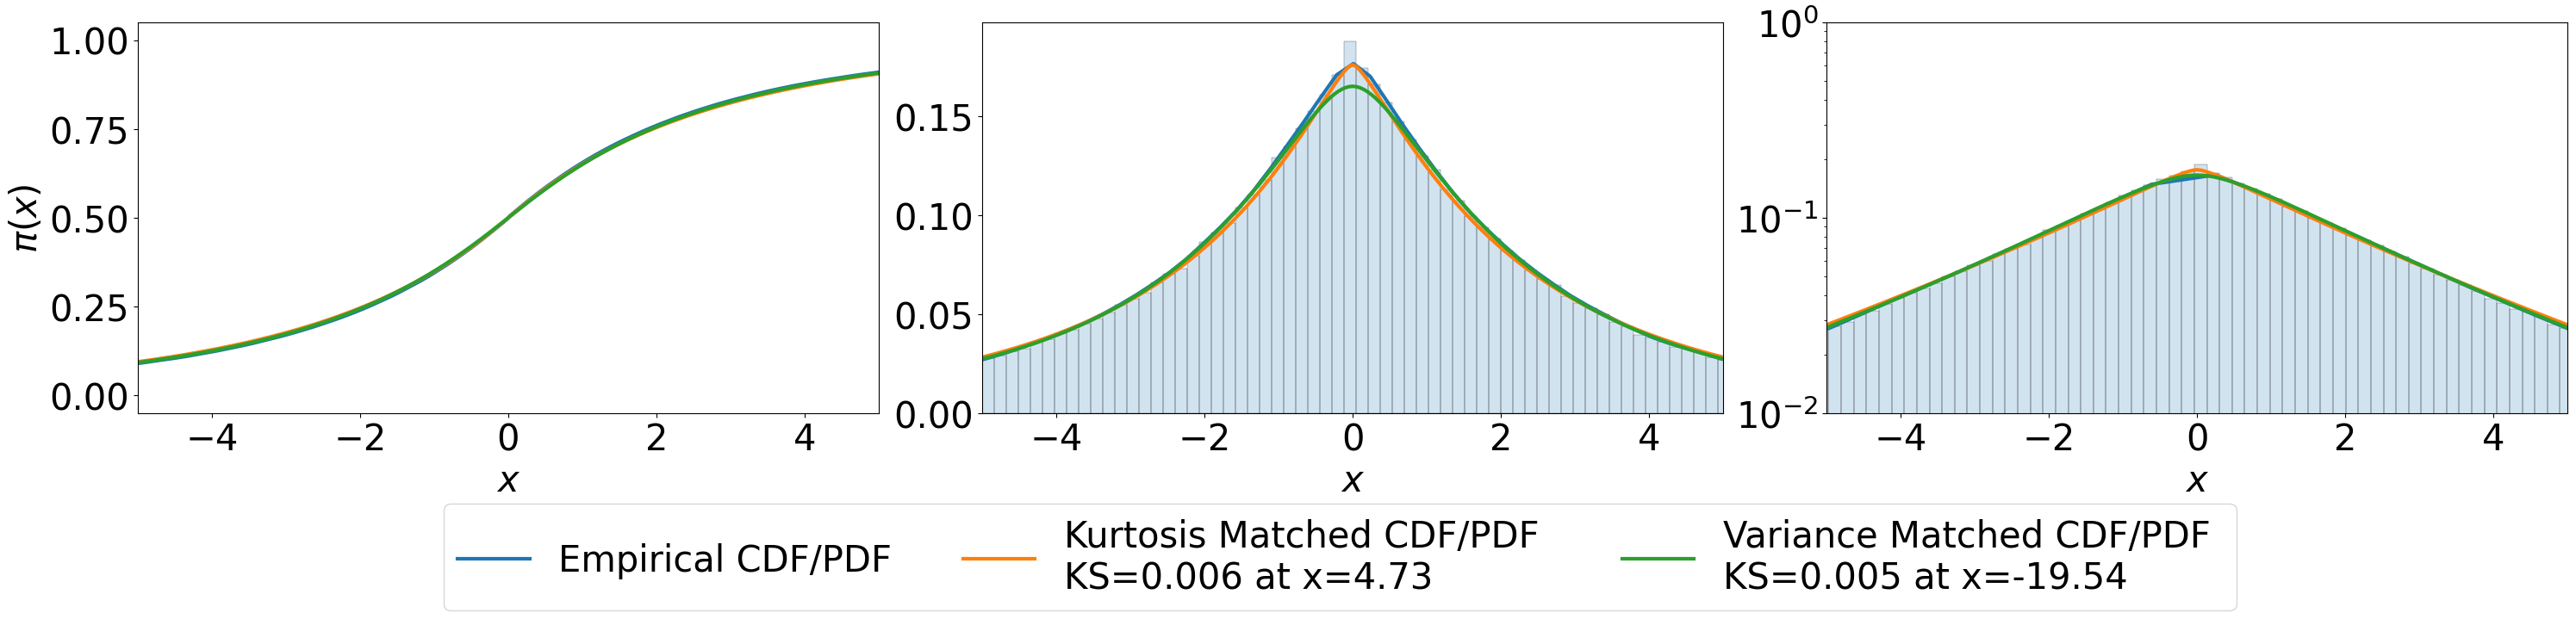

In [8]:
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded / 2)
    upper_bound = np.percentile(sample, 100 - percent_excluded / 2)
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 0.5), np.percentile(sample, 99.5))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 20000000)
    print(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]))

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

    if interval:
        ax1.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n + 1) / n, label='Empirical CDF/PDF', linewidth=linewidth)
        result1 = stats.ks_1samp(original_sample, null_cdf1)
        result2 = stats.ks_1samp(original_sample, null_cdf2)
        distance1, location1 = result1.statistic, np.round(result1.statistic_location, 2)
        distance2, location2 = result2.statistic, np.round(result2.statistic_location, 2)

        paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
        paramtext2 = rf"$r={params2[0]}, \eta={params2[1]}, \vartheta={np.format_float_scientific(params2[2], precision=2)}$"
        
        paramtext1 = f"Kurtosis Matched CDF/PDF \nKS={np.round(distance1, 4)} at x={4.73}"
        paramtext2 = f"Variance Matched CDF/PDF \nKS={np.round(distance2, 4)} at x={-19.54}"
        
        print(location1, location2)
        ax1.plot(xs, null_cdf1(xs), label=paramtext1, linewidth=linewidth)
        ax1.plot(xs, null_cdf2(xs), label=paramtext2, linewidth=linewidth)

    if interval:
        ax2.set_xlim(left=interval[0], right=interval[1])

    if len(sample) > 0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method=bw, ax=ax2, label=f'Empirical PDF (KDE, bw={bw})', linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth=binwidth, stat='density', label=f'Empirical PDF ({100 - percent_excluded}% of sample)', alpha=0.2)
    ax2.plot(xs_pdf1, null_pdf1, label='Computed PDF (params1)', linewidth=linewidth)
    ax2.plot(xs_pdf2, null_pdf2, label='Computed PDF (params2)', linewidth=linewidth)

    if interval:
        ax3.set_xlim(left=interval[0], right=interval[1])
    ax3.set_ylim(bottom=10**-2, top=1)

    if len(sample) > 0:
        sns.kdeplot(ax=ax3, x=sample, bw_method=bw_log, log_scale=[False, True], label=f"Empirical PDF (KDE, bw={bw_log})", linewidth=linewidth)
        if plot_hist:
            sns.histplot(sample, ax=ax3, binwidth=binwidth, stat="density", log=True, bins=1000, alpha=0.2, color='#1f77b4', label=f'Empirical PDF ({100 - percent_excluded}% of sample)')

    ax3.plot(xs_pdf1, null_pdf1, label="Computed PDF (params1)", linewidth=linewidth)
    ax3.plot(xs_pdf2, null_pdf2, label="Computed PDF (params2)", linewidth=linewidth)

    # Move legend outside the plot and make it common for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.05), ncol=4, fontsize=fontsize, markerscale=50)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.set_ylabel(r"$\pi(x)$", fontsize=fontsize)
    ax2.set_ylabel("")
    ax3.set_ylabel("")

    ax1.set_xlabel(r"$x$", fontsize=fontsize)
    ax2.set_xlabel(r"$x$", fontsize=fontsize)
    ax3.set_xlabel(r"$x$", fontsize=fontsize)

    ax1.set_xlim((-5, 5))
    ax2.set_xlim((-5, 5))
    ax3.set_xlim((-5, 5))

    plt.tight_layout()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, "fit_kurtosis_variance.jpg")
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')

    plt.show()




In [9]:
paramtext1 = rf"$r={params1[0]}, \eta={params1[1]}, \vartheta={np.format_float_scientific(params1[2], precision=2)}$"
paramtext2 = rf"$r={params2[0]}, \eta={params2[1]}, \vartheta={np.format_float_scientific(params2[2], precision=2)}$"
paramtext1 

'$r=0.4, \\eta=-0.1, \\vartheta=5.96e-01$'